### Import Libs

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import DropConstantFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

### Load Data

In [2]:
df = pd.read_csv('../processed_data/features-target.csv')

In [3]:
df.head()

,machineID,dtRef,volt_mean_1_days,volt_std_1_days,volt_min_1_days,volt_max_1_days,volt_max_rate_1_days,pressure_mean_1_days,pressure_std_1_days,pressure_min_1_days,...,days_since_last_error,days_since_last_rep,model,age,count_comp2_last15days,count_comp4_last15days,count_comp3_last15days,count_comp1_last15days,avg_days_between_mtn,target
0,1,2015-02-02,164.947744,12.526438,142.559604,190.985830,1.120290,100.862632,7.021747,87.529260,...,5.833333,12.75,model3,18,0.0,0.0,0.0,0.0,33.285714,0.0
1,2,2015-02-02,167.388450,17.700100,135.350069,216.299453,1.268775,99.735153,9.236172,81.742015,...,20.416667,14.75,model4,7,0.0,0.0,0.0,0.0,54.000000,0.0
2,3,2015-02-02,166.065714,13.018281,139.126762,192.111761,1.126894,100.077484,12.097118,78.093179,...,4.291667,10.75,model3,8,0.0,0.0,0.0,0.0,44.000000,1.0
3,4,2015-02-02,173.652648,12.136008,152.527285,192.391288,1.128534,100.701927,10.328765,81.286954,...,16.750000,15.75,model3,7,0.0,0.0,0.0,0.0,53.750000,0.0
4,5,2015-02-02,167.550151,13.873202,140.783515,195.575448,1.147212,102.314697,12.696205,76.244390,...,1.208333,8.75,model3,2,0.0,0.0,0.0,0.0,32.400000,0.0


The creation of the dataset is described in the notebook "pdm-exploration-features.ipynb".

### Data Description

In [4]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 31600
Number of columns: 97


In [5]:
df.dtypes

machineID                   int64
dtRef                      object
volt_mean_1_days          float64
volt_std_1_days           float64
volt_min_1_days           float64
                           ...   
count_comp4_last15days    float64
count_comp3_last15days    float64
count_comp1_last15days    float64
avg_days_between_mtn      float64
target                    float64
Length: 97, dtype: object

In [6]:
df.isna().sum()

machineID                 0
dtRef                     0
volt_mean_1_days          0
volt_std_1_days           0
volt_min_1_days           0
                         ..
count_comp4_last15days    0
count_comp3_last15days    0
count_comp1_last15days    0
avg_days_between_mtn      0
target                    0
Length: 97, dtype: int64

The variable "days_since_last_error/failure" should indicate if a variable had an error before or not. So, since it has nan values, we can assume machines that didn't have errors or failures and this value should be very high. This is a consideration for the pre-processing part.

In [7]:
df.describe()

,machineID,volt_mean_1_days,volt_std_1_days,volt_min_1_days,volt_max_1_days,volt_max_rate_1_days,pressure_mean_1_days,pressure_std_1_days,pressure_min_1_days,pressure_max_1_days,...,days_since_last_failure,days_since_last_error,days_since_last_rep,age,count_comp2_last15days,count_comp4_last15days,count_comp3_last15days,count_comp1_last15days,avg_days_between_mtn,target
count,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,31600.000000,...,29908.000000,31580.000000,31600.000000,31600.000000,31600.0,31600.0,31600.0,31600.0,31600.000000,31600.000000
mean,50.500000,170.760869,14.912348,141.446891,200.167114,1.174146,100.849249,10.053176,81.112933,120.645158,...,41.273556,9.717854,9.460032,11.330000,0.0,0.0,0.0,0.0,23.125695,0.151424
std,28.866527,4.722131,2.257656,8.309407,8.726679,0.051189,4.705546,1.718139,6.258213,7.246184,...,42.545864,9.332403,7.166314,5.827708,0.0,0.0,0.0,0.0,7.764057,0.358467
min,1.000000,157.745683,7.383772,97.333604,176.709005,1.036544,90.973896,4.513850,51.237106,101.486195,...,0.750000,0.000000,0.750000,0.000000,0.0,0.0,0.0,0.0,12.571429,0.000000
25%,25.750000,168.036829,13.343677,136.396166,194.093201,1.138517,98.682687,8.924697,77.553506,116.058943,...,12.750000,2.875000,4.750000,6.750000,0.0,0.0,0.0,0.0,18.066667,0.000000
50%,50.500000,170.191852,14.836994,141.811621,199.141258,1.168128,100.114529,9.921164,81.210152,119.372650,...,28.750000,6.875000,8.750000,12.000000,0.0,0.0,0.0,0.0,20.705882,0.000000
75%,75.250000,172.472412,16.413043,146.792443,204.924431,1.202051,101.614597,10.988817,84.409845,123.341198,...,53.750000,13.583333,12.750000,16.000000,0.0,0.0,0.0,0.0,25.555556,0.000000
max,100.000000,218.265191,26.725027,191.645382,255.124717,1.496518,152.314600,28.399538,136.619446,185.951998,...,292.750000,79.000000,157.750000,20.000000,0.0,0.0,0.0,0.0,70.000000,1.000000


The idea here is the pre-processing and modeling part. So, I will not take into account all other steps.

### Split Train / OOT

In [8]:
df_train = df[df['dtRef'] <= '2015-08-31']

df_oot = df[df['dtRef'] > '2015-08-31']

The idea here is to separate our database in 2 things: Train and Test on new data.

- Train dataset is used to TRAIN and VALIDATE our model, to do so, I will consider the examples before december.
- Out of Time dataset is used only to TEST our model in data that is never seen by the model. This split is considered only after december.

### Pre-Processing

In [9]:
# Split the dataset in trian and 
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(['dtRef', 'machineID', 'target'], axis = 1), df_train['target'], test_size = 0.3, random_state=42)


In [10]:
# Conver values to integer instead of float
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [11]:
print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('y_train:', y_train.shape)
print('y_val:', y_val.shape)

X_train: (14770, 94)
X_val: (6330, 94)
y_train: (14770,)
y_val: (6330,)


In [12]:
# Target proportion
y_train.value_counts(normalize = True)

target
0    0.846987
1    0.153013
Name: proportion, dtype: float64

In [13]:
# Target proportion
y_val.value_counts(normalize = True)

target
0    0.842654
1    0.157346
Name: proportion, dtype: float64

In [14]:
df_train.dtypes

machineID                   int64
dtRef                      object
volt_mean_1_days          float64
volt_std_1_days           float64
volt_min_1_days           float64
                           ...   
count_comp4_last15days    float64
count_comp3_last15days    float64
count_comp1_last15days    float64
avg_days_between_mtn      float64
target                    float64
Length: 97, dtype: object

In [15]:
df.columns

Index(['machineID', 'dtRef', 'volt_mean_1_days', 'volt_std_1_days',
       'volt_min_1_days', 'volt_max_1_days', 'volt_max_rate_1_days',
       'pressure_mean_1_days', 'pressure_std_1_days', 'pressure_min_1_days',
       'pressure_max_1_days', 'pressure_max_rate_1_days', 'rotate_mean_1_days',
       'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_1_days',
       'rotate_max_rate_1_days', 'vibration_mean_1_days',
       'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_1_days',
       'vibration_max_rate_1_days', 'volt_mean_3_days', 'volt_std_3_days',
       'volt_min_3_days', 'volt_max_3_days', 'volt_max_rate_3_days',
       'pressure_mean_3_days', 'pressure_std_3_days', 'pressure_min_3_days',
       'pressure_max_3_days', 'pressure_max_rate_3_days', 'rotate_mean_3_days',
       'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_3_days',
       'rotate_max_rate_3_days', 'vibration_mean_3_days',
       'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_

In [16]:
features = ['volt_mean_1_days', 'volt_std_1_days',
       'volt_min_1_days', 'volt_max_1_days', 'volt_max_rate_1_days',
       'pressure_mean_1_days', 'pressure_std_1_days', 'pressure_min_1_days',
       'pressure_max_1_days', 'pressure_max_rate_1_days', 'rotate_mean_1_days',
       'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_1_days',
       'rotate_max_rate_1_days', 'vibration_mean_1_days',
       'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_1_days',
       'vibration_max_rate_1_days', 'volt_mean_3_days', 'volt_std_3_days',
       'volt_min_3_days', 'volt_max_3_days', 'volt_max_rate_3_days',
       'pressure_mean_3_days', 'pressure_std_3_days', 'pressure_min_3_days',
       'pressure_max_3_days', 'pressure_max_rate_3_days', 'rotate_mean_3_days',
       'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_3_days',
       'rotate_max_rate_3_days', 'vibration_mean_3_days',
       'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_3_days',
       'vibration_max_rate_3_days', 'volt_mean_7_days', 'volt_std_7_days',
       'volt_min_7_days', 'volt_max_7_days', 'volt_max_rate_7_days',
       'pressure_mean_7_days', 'pressure_std_7_days', 'pressure_min_7_days',
       'pressure_max_7_days', 'pressure_max_rate_7_days', 'rotate_mean_7_days',
       'rotate_std_7_days', 'rotate_min_7_days', 'rotate_max_7_days',
       'rotate_max_rate_7_days', 'vibration_mean_7_days',
       'vibration_std_7_days', 'vibration_min_7_days', 'vibration_max_7_days',
       'vibration_max_rate_7_days', 'volt_mean_14_days', 'volt_std_14_days',
       'volt_min_14_days', 'volt_max_14_days', 'volt_max_rate_14_days',
       'pressure_mean_14_days', 'pressure_std_14_days', 'pressure_min_14_days',
       'pressure_max_14_days', 'pressure_max_rate_14_days',
       'rotate_mean_14_days', 'rotate_std_14_days', 'rotate_min_14_days',
       'rotate_max_14_days', 'rotate_max_rate_14_days',
       'vibration_mean_14_days', 'vibration_std_14_days',
       'vibration_min_14_days', 'vibration_max_14_days',
       'volt_count_exceed_thr_24h', 'pressure_count_exceed_thr_24h',
       'rotate_count_exceed_thr_24h', 'vibration_count_exceed_thr_24h',
       'days_since_last_failure', 'days_since_last_error',
       'days_since_last_rep', 'age', 'count_comp2_last15days',
       'count_comp4_last15days', 'count_comp3_last15days',
       'count_comp1_last15days', 'avg_days_between_mtn','model']

In [17]:
# Numerical features to be pre-processed by the pipeline
numeric_features = ['volt_mean_1_days', 'volt_std_1_days',
       'volt_min_1_days', 'volt_max_1_days', 'volt_max_rate_1_days',
       'pressure_mean_1_days', 'pressure_std_1_days', 'pressure_min_1_days',
       'pressure_max_1_days', 'pressure_max_rate_1_days', 'rotate_mean_1_days',
       'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_1_days',
       'rotate_max_rate_1_days', 'vibration_mean_1_days',
       'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_1_days',
       'vibration_max_rate_1_days', 'volt_mean_3_days', 'volt_std_3_days',
       'volt_min_3_days', 'volt_max_3_days', 'volt_max_rate_3_days',
       'pressure_mean_3_days', 'pressure_std_3_days', 'pressure_min_3_days',
       'pressure_max_3_days', 'pressure_max_rate_3_days', 'rotate_mean_3_days',
       'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_3_days',
       'rotate_max_rate_3_days', 'vibration_mean_3_days',
       'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_3_days',
       'vibration_max_rate_3_days', 'volt_mean_7_days', 'volt_std_7_days',
       'volt_min_7_days', 'volt_max_7_days', 'volt_max_rate_7_days',
       'pressure_mean_7_days', 'pressure_std_7_days', 'pressure_min_7_days',
       'pressure_max_7_days', 'pressure_max_rate_7_days', 'rotate_mean_7_days',
       'rotate_std_7_days', 'rotate_min_7_days', 'rotate_max_7_days',
       'rotate_max_rate_7_days', 'vibration_mean_7_days',
       'vibration_std_7_days', 'vibration_min_7_days', 'vibration_max_7_days',
       'vibration_max_rate_7_days', 'volt_mean_14_days', 'volt_std_14_days',
       'volt_min_14_days', 'volt_max_14_days', 'volt_max_rate_14_days',
       'pressure_mean_14_days', 'pressure_std_14_days', 'pressure_min_14_days',
       'pressure_max_14_days', 'pressure_max_rate_14_days',
       'rotate_mean_14_days', 'rotate_std_14_days', 'rotate_min_14_days',
       'rotate_max_14_days', 'rotate_max_rate_14_days',
       'vibration_mean_14_days', 'vibration_std_14_days',
       'vibration_min_14_days', 'vibration_max_14_days',
       'volt_count_exceed_thr_24h', 'pressure_count_exceed_thr_24h',
       'rotate_count_exceed_thr_24h', 'vibration_count_exceed_thr_24h',
       'days_since_last_failure', 'days_since_last_error',
       'days_since_last_rep', 'age', 'count_comp2_last15days',
       'count_comp4_last15days', 'count_comp3_last15days',
       'count_comp1_last15days', 'avg_days_between_mtn']

# Categorical features to be pre-processed by the pipeline
categorical_features = ['model']

# The response
target = 'target'

# Features to fill missing values
imputer_features = ['days_since_last_failure', 'days_since_last_error']

# Imputer transformation
imputer_transformer = Pipeline(
    steps=[("imputer", ArbitraryNumberImputer(arbitrary_number=10000))]
)

# Numerical transformations
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

# Categorical transformations
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
]
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
    
)


### Feature Selection

In [18]:
smart_corr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.7,
    missing_values="raise",
    selection_method="variance"
)

In [19]:
feat_selector_pipe = Pipeline([
    ('imputer', ArbitraryNumberImputer(arbitrary_number=10000, variables = imputer_features)),
    ('preprocessor', preprocessor),
    ('selector_cte', DropConstantFeatures()),
    ('selector_corr', smart_corr)
])


df_feat = feat_selector_pipe.fit_transform(X_train, y_train)

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))


In [20]:
all_vars = list(feat_selector_pipe['preprocessor'].get_feature_names_out())
idx = [int(x[1:]) for x in df_feat.columns]

selected_features = [all_vars[i].split('__')[1] for i in idx]

print("Features:", selected_features)
print("Number of Selected Features:", len(selected_features))

Features: ['volt_mean_1_days', 'volt_std_1_days', 'volt_min_1_days', 'volt_max_1_days', 'pressure_std_1_days', 'pressure_min_1_days', 'pressure_max_rate_1_days', 'rotate_mean_1_days', 'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_1_days', 'vibration_mean_1_days', 'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_1_days', 'volt_mean_3_days', 'volt_std_3_days', 'volt_min_3_days', 'volt_max_rate_3_days', 'pressure_min_3_days', 'pressure_max_rate_3_days', 'rotate_mean_3_days', 'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_rate_3_days', 'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_rate_3_days', 'volt_min_7_days', 'volt_max_rate_7_days', 'pressure_min_7_days', 'rotate_min_7_days', 'rotate_max_rate_7_days', 'vibration_min_7_days', 'vibration_max_rate_7_days', 'volt_mean_14_days', 'volt_std_14_days', 'volt_min_14_days', 'volt_max_rate_14_days', 'pressure_mean_14_days', 'pressure_min_14_days', 'pressure_max_rate_14_days', 'rotate_mean_14_days', 'ro

### Modeling

In [21]:
def evaluate(y_true, y_pred_prob, threshold = 0.5):
    # convert probabilities to binary predictions
    y_pred = (y_pred_prob > threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC-AUC:", roc_auc)
    

In [22]:
def evaluate_models(model_list, X, y, cv = 5, threshold = 0.5):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    results_df = pd.DataFrame([], columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1-score', 'Train ROC-AUC', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1-Score', 'Validation ROC-AUC'])

    for name, model in model_list:

        train_accuracy = []
        train_precision  = []
        train_recall  = []

        val_accuracy = []
        val_precision = []
        val_recall = []

        train_f1 = []
        val_f1 = []

        train_roc_auc = []
        val_roc_auc = []

        for train_index, val_index in skf.split(X, y):

            X_train_fold = X.iloc[train_index, :]
            X_val_fold = X.iloc[val_index, :]

            y_train_fold = y.iloc[train_index]
            y_val_fold = y.iloc[val_index]

            model_pipe = Pipeline([
                                ('imputer', ArbitraryNumberImputer(arbitrary_number=10000, variables = imputer_features)),
                                ('preprocessor', preprocessor),
                                ('selector_cte', DropConstantFeatures()),
                                ('selector_corr', smart_corr),
                                ('model', model)
                            ])
            
            model_pipe.fit(X_train_fold, y_train_fold)

            # Predict on the training and testing sets
            y_train_pred_prob = model_pipe.predict_proba(X_train_fold)
            y_train_pred = (y_train_pred_prob[:,1] > threshold).astype(int)
            y_val_pred_prob = model_pipe.predict_proba(X_val_fold)
            y_val_pred = (y_val_pred_prob[:,1] > threshold).astype(int)

            

            # Calculate the evaluation metrics for the training set
            train_accuracy.append(accuracy_score(y_train_fold, y_train_pred))
            train_precision.append(precision_score(y_train_fold, y_train_pred))
            train_recall.append(recall_score(y_train_fold, y_train_pred))
            train_f1.append(f1_score(y_train_fold, y_train_pred))
            train_roc_auc.append(roc_auc_score(y_train_fold, y_train_pred_prob[:, 1]))
            # Calculate the evaluation metrics for the validation set
            val_accuracy.append(accuracy_score(y_val_fold, y_val_pred))
            val_precision.append(precision_score(y_val_fold, y_val_pred))
            val_recall.append(recall_score(y_val_fold, y_val_pred))
            val_f1.append(f1_score(y_val_fold, y_val_pred))
            val_roc_auc.append(roc_auc_score(y_val_fold, y_val_pred_prob[:, 1]))



        model_metrics = [name, np.mean(train_accuracy), np.mean(train_precision), np.mean(train_recall), np.mean(train_f1), np.mean(train_roc_auc), np.mean(val_accuracy), np.mean(val_precision), np.mean(val_recall), np.mean(val_f1), np.mean(val_roc_auc)]

        results_df = pd.concat([results_df, pd.DataFrame([model_metrics], columns = ['Model', 'Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1-score', 'Train ROC-AUC', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation F1-Score', 'Validation ROC-AUC'])], ignore_index=True)
        
    return results_df

In [23]:
results_df = evaluate_models([('RandomForestClassifier', RandomForestClassifier(random_state = 42)), ('XGBoost', XGBClassifier(random_state = 42)), ('CatBoostClassifier', CatBoostClassifier(random_state = 42, verbose = False))], X_train, y_train)
results_df

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))


KeyboardInterrupt: 

### Hyper-parameter Fine Tuning

In [26]:
model = CatBoostClassifier(random_state = 42,
                           n_estimators = 300,
                           depth = 3,
                           reg_lambda = 3,
                           verbose = False)

results_df_tuning = evaluate_models([('CatBoostClassifier', model)], X_train, y_train)
results_df_tuning

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

KeyboardInterrupt: 

In [27]:
model = CatBoostClassifier(random_state = 42,
                           n_estimators = 300,
                           depth = 3,
                           reg_lambda = 5,
                           verbose = False)

results_df_tuning = evaluate_models([('CatBoostClassifier', model)], X_train, y_train, threshold = 0.3)
results_df_tuning

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

,Model,Train Accuracy,Train Precision,Train Recall,Train F1-score,Train ROC-AUC,Validation Accuracy,Validation Precision,Validation Recall,Validation F1-Score,Validation ROC-AUC
0,CatBoostClassifier,0.88436,0.611573,0.670243,0.639482,0.927631,0.87258,0.576638,0.633628,0.603352,0.914026


Great, our model is not overfitting anymore!

### Evaluation

In [28]:
model = CatBoostClassifier(random_state = 42,
                           n_estimators = 300,
                           depth = 3,
                           reg_lambda = 5,
                           verbose = False)

model_pipe = Pipeline([
                        ('imputer', ArbitraryNumberImputer(arbitrary_number=10000, variables = imputer_features)),
                        ('preprocessor', preprocessor),
                        ('selector_cte', DropConstantFeatures()),
                        ('selector_corr', smart_corr),
                        ('model', model)
                        ])

model_pipe.fit(X_train, y_train)

c:\Users\BRUM\Anaconda3\envs\pred-maintenance\Lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))


Pipeline(steps=[('imputer',
                 ArbitraryNumberImputer(arbitrary_number=10000,
                                        variables=['days_since_last_failure',
                                                   'days_since_last_error'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['volt_mean_1_days',
                                                   'volt_std_1_days',
                                                   'volt_min_1_days',
                                                   'volt_max_1_days',
                                                   'volt_max_rate_1...
                                                   'pressure_min_3_days',
                                                   'pressure_max_3_days',
                                                   'pressure_max_rate_3_days', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['model'])])),
                ('selector_cte', DropConstantFeatures()),
                ('selector_corr',
                 SmartCorrelatedSelection(missing_values='raise',
                                          selection_method='variance',
                                          threshold=0.7)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x00000156B2A61290>)])

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [31]:
optimal_thr = 0.3
y_pred_val_prob = model_pipe.predict_proba(X_val)
y_pred_val = (y_pred_val_prob > optimal_thr).astype(int)[:, 1]

In [32]:
TP, FP, TN, FN = perf_measure(y_val.values, y_pred_val)

In [33]:
# Thr = 0.3
print("TP:",TP)
print("FP:",FP)
print("TN:",TN)
print("FN:",FN)

TP: 638
FP: 464
TN: 4870
FN: 358


In [34]:
# Costs 
unnecessary_maintenance = 1500
appropriate_maintenance = 7500
run_to_failure = 30000

In [49]:
# Here, I'm dividing all numbers by 7 because I receive always a window of 7 positive values. So, in practive, only the first one is considered the TRUE positive
# Maybe I'm overestimating this numbers for FP and FN, but it's ok for now.
total_cost_unnecessary_maintenance = unnecessary_maintenance * FP
total_cost_appropriate_maintenance = appropriate_maintenance * TP
total_cost_run_to_failure = run_to_failure * FN
total_cost = total_cost_unnecessary_maintenance + total_cost_appropriate_maintenance + total_cost_run_to_failure

print("total_cost_unnecessary_maintenance: k$", total_cost_unnecessary_maintenance/1e3)
print("total_cost_appropriate_maintenance: k$", total_cost_appropriate_maintenance/1e3)
print("total_cost_run_to_failure: k$", total_cost_run_to_failure/1e3)
print("total_cost k$:", total_cost/1e3)

print('Average Cost per Machine: k$', (total_cost/1e3)/100)


total_cost_unnecessary_maintenance: k$ 696.0
total_cost_appropriate_maintenance: k$ 4785.0
total_cost_run_to_failure: k$ 10740.0
total_cost k$: 16221.0
Average Cost per Machine: k$ 162.21


In [36]:
pdm_failures = pd.read_csv('../data/PdM_failures.csv')
pdm_maint = pd.read_csv('../data/PdM_maint.csv')

In [37]:
start = '2015-02-01'
end = '2015-12-15'

In [38]:
pdm_failures = pdm_failures[(pdm_failures['datetime'] > start) & (pdm_failures['datetime'] <= end)]
pdm_maint = pdm_maint[(pdm_maint['datetime'] > start) & (pdm_maint['datetime'] <= end)]

In [39]:
n_maint = pdm_maint['datetime'].nunique()
n_failures = pdm_failures['datetime'].nunique()
# Assuming 30% of maintenances are unnecessary
n_unnecessary = 0.3*n_maint

baseline_total_cost_unnecessary_maintenance = unnecessary_maintenance * n_unnecessary
baseline_total_cost_appropriate_maintenance = appropriate_maintenance * n_maint
baseline_total_cost_run_to_failure = run_to_failure * n_failures

baseline_total_cost = baseline_total_cost_appropriate_maintenance + baseline_total_cost_run_to_failure + baseline_total_cost_unnecessary_maintenance


print("baseline_total_cost_unnecessary_maintenance: k$", baseline_total_cost_unnecessary_maintenance/1e3)
print("baseline_total_cost_appropriate_maintenance: k$", baseline_total_cost_appropriate_maintenance/1e3)
print("baseline_total_cost_run_to_failure: k$", baseline_total_cost_run_to_failure/1e3)
print("baseline_total_cost k$:", baseline_total_cost/1e3)

print('Average Cost per Machine: k$', (baseline_total_cost/1e3)/100)


baseline_total_cost_unnecessary_maintenance: k$ 140.4
baseline_total_cost_appropriate_maintenance: k$ 2340.0
baseline_total_cost_run_to_failure: k$ 7830.0
baseline_total_cost k$: 10310.4
Average Cost per Machine: k$ 103.104


### Practical Application

In [40]:
df_oot.columns

Index(['machineID', 'dtRef', 'volt_mean_1_days', 'volt_std_1_days',
       'volt_min_1_days', 'volt_max_1_days', 'volt_max_rate_1_days',
       'pressure_mean_1_days', 'pressure_std_1_days', 'pressure_min_1_days',
       'pressure_max_1_days', 'pressure_max_rate_1_days', 'rotate_mean_1_days',
       'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_1_days',
       'rotate_max_rate_1_days', 'vibration_mean_1_days',
       'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_1_days',
       'vibration_max_rate_1_days', 'volt_mean_3_days', 'volt_std_3_days',
       'volt_min_3_days', 'volt_max_3_days', 'volt_max_rate_3_days',
       'pressure_mean_3_days', 'pressure_std_3_days', 'pressure_min_3_days',
       'pressure_max_3_days', 'pressure_max_rate_3_days', 'rotate_mean_3_days',
       'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_3_days',
       'rotate_max_rate_3_days', 'vibration_mean_3_days',
       'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_

In [41]:
df_train.columns

Index(['machineID', 'dtRef', 'volt_mean_1_days', 'volt_std_1_days',
       'volt_min_1_days', 'volt_max_1_days', 'volt_max_rate_1_days',
       'pressure_mean_1_days', 'pressure_std_1_days', 'pressure_min_1_days',
       'pressure_max_1_days', 'pressure_max_rate_1_days', 'rotate_mean_1_days',
       'rotate_std_1_days', 'rotate_min_1_days', 'rotate_max_1_days',
       'rotate_max_rate_1_days', 'vibration_mean_1_days',
       'vibration_std_1_days', 'vibration_min_1_days', 'vibration_max_1_days',
       'vibration_max_rate_1_days', 'volt_mean_3_days', 'volt_std_3_days',
       'volt_min_3_days', 'volt_max_3_days', 'volt_max_rate_3_days',
       'pressure_mean_3_days', 'pressure_std_3_days', 'pressure_min_3_days',
       'pressure_max_3_days', 'pressure_max_rate_3_days', 'rotate_mean_3_days',
       'rotate_std_3_days', 'rotate_min_3_days', 'rotate_max_3_days',
       'rotate_max_rate_3_days', 'vibration_mean_3_days',
       'vibration_std_3_days', 'vibration_min_3_days', 'vibration_max_

In [42]:
y_oot_pred = model_pipe.predict_proba(df_oot.drop(['target', 'dtRef', 'machineID'], axis = 1))
y_train_pred = model_pipe.predict_proba(df_train.drop(['target', 'dtRef', 'machineID'], axis = 1))

In [43]:
df_oot['proba'] = y_oot_pred[:, 1]
df_train['proba'] = y_train_pred[:, 1]

C:\Users\BRUM\AppData\Local\Temp\ipykernel_13684\3652388224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oot['proba'] = y_oot_pred[:, 1]
C:\Users\BRUM\AppData\Local\Temp\ipykernel_13684\3652388224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['proba'] = y_train_pred[:, 1]


In [55]:
# 51, 19, 99, 85, 82, 81, 80, 79, 70
df_oot2 = df_oot[['dtRef', 'machineID', 'proba', 'target']]
machine = 19

In [56]:
df_oot2 = df_oot2[df_oot2['machineID'] == machine]

warning_signal_day = df_oot2.loc[df_oot2[df_oot2['proba'] > 0.1].index[0], 'dtRef']
real_failure_day = df_oot2.loc[df_oot2[df_oot2['target'] == 1].index[-1], 'dtRef']

daysdiff = (pd.to_datetime(real_failure_day) - pd.to_datetime(warning_signal_day))/ pd.Timedelta(days = 1)


In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Machine 19')

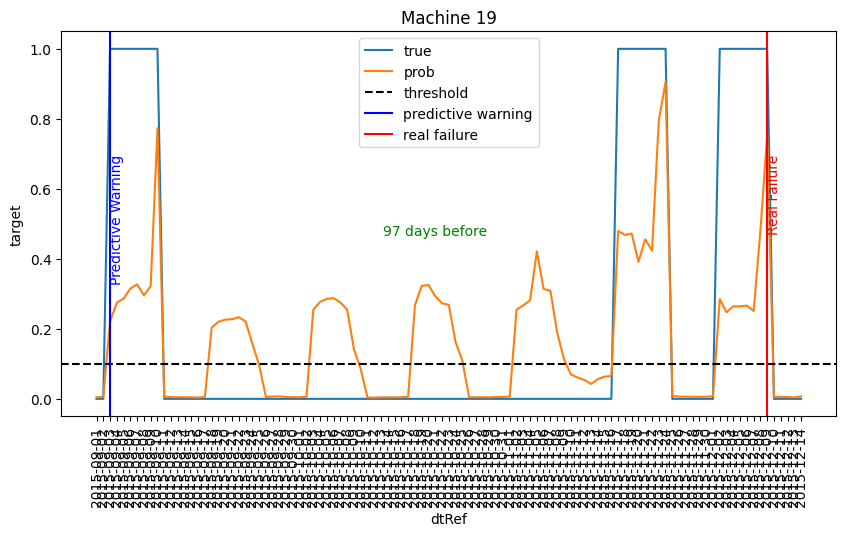

In [58]:
# Get the index positions of the dates
warning_signal_index = df_oot2.reset_index().index[df_oot2['dtRef'] == warning_signal_day][0]
real_failure_index = df_oot2.reset_index().index[df_oot2['dtRef'] == real_failure_day][0]

# Calculate the midpoint index
midpoint_index = (warning_signal_index + real_failure_index) // 2


plt.figure(1, figsize=(10, 5))
sns.lineplot(x='dtRef', y='target', data=df_oot2, label='true')
sns.lineplot(x='dtRef', y='proba', data=df_oot2, label='prob')
plt.axhline(0.1, linestyle='--', color='k', label='threshold')
plt.axvline(warning_signal_day, color='b', label='predictive warning')
plt.axvline(real_failure_day, color='r', label='real failure')

plt.xticks(rotation=90)
plt.legend()

# Add annotation for predictive warning
plt.text(warning_signal_day, 0.7, 'Predictive Warning', color='b', verticalalignment='top', rotation=90)

# Add annotation for real failure
plt.text(real_failure_day, 0.7, 'Real Failure', color='r', verticalalignment='top', rotation=90)

# Add label at the midpoint
plt.text(midpoint_index, 0.5, f'{int(daysdiff)} days before', color='g', ha='center', va='top')

plt.title('Machine ' + str(machine))

In [59]:
df_oot2[df_oot2['proba'] > 0.2]

,dtRef,machineID,proba,target
21318,2015-09-03,19,0.221009,1.0
21418,2015-09-04,19,0.274858,1.0
21518,2015-09-05,19,0.286270,1.0
21618,2015-09-06,19,0.315218,1.0
21718,2015-09-07,19,0.327234,1.0
21818,2015-09-08,19,0.295293,1.0
21918,2015-09-09,19,0.322754,1.0
22018,2015-09-10,19,0.773181,1.0
22818,2015-09-18,19,0.203691,0.0
22918,2015-09-19,19,0.220386,0.0


### Consideration

- The validation is not good, need to change to time-series structure.
- The model is very useful on the OOT base.